In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
from datetime import datetime
from apyori import apriori
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
sns.set()

In [2]:
ML_LIBRARIES = [
    "tensorflow",
    "torch",
    "theano",
    "keras",
]
PLOTS_PATH = './plots'

def save_plot(plot, file_name, dpi=400):
    plot.savefig(f'{PLOTS_PATH}/{file_name}', dpi=400)

In [3]:
releases_raw = pd.read_csv('../data/csv/releases.csv')

imports = pd.read_csv('../data/csv/imports.csv')
import_diffs = pd.read_csv('../data/csv/import_diffs.csv')
repo_imports = pd.read_csv('../data/csv/repo_imports.csv')
repo_import_diffs = pd.read_csv('../data/csv/repo_import_diffs.csv')
repo_import_diffs_timeline = pd.read_csv('../data/csv/repo_import_diffs_timeline.csv')

calls = pd.read_csv('../data/csv/calls.csv')
call_diffs = pd.read_csv('../data/csv/call_diffs.csv')
repo_calls = pd.read_csv('../data/csv/repo_calls.csv')
repo_call_diffs = pd.read_csv('../data/csv/repo_call_diffs.csv')
repo_call_diffs_timeline = pd.read_csv('../data/csv/repo_call_diffs_timeline.csv')

In [4]:
releases_raw['date'] = pd.to_datetime(releases_raw['date_time'])
releases = releases_raw.drop(columns=['year', 'month', 'day', 'time', 'date_time'])

import_diffs['type'] = import_diffs['type'].astype('category')
repo_import_diffs['type'] = repo_import_diffs['type'].astype('category')
repo_import_diffs_timeline['date'] = pd.to_datetime(repo_import_diffs_timeline['date'])

call_diffs['type'] = call_diffs['type'].astype('category')
repo_call_diffs['type'] = repo_call_diffs['type'].astype('category')
repo_call_diffs_timeline['date'] = pd.to_datetime(repo_call_diffs_timeline['date'])


In [5]:
def get_primary_import(name, module):
    if not pd.isna(module):
        return module
    return name

imports['primary_import'] = imports.apply(lambda row: get_primary_import(row['name'], row['module']), axis=1)
import_diffs['primary_import'] = import_diffs.apply(lambda row: get_primary_import(row['import_name'], row['import_module']), axis=1)
repo_imports['primary_import'] = repo_imports.apply(lambda row: get_primary_import(row['import_name'], row['import_module']), axis=1)
repo_import_diffs['primary_import'] = repo_import_diffs.apply(lambda row: get_primary_import(row['import_name'], row['import_module']), axis=1)

In [6]:
print(f"repos: {len(releases['repo'].unique())}")
print(f"releases: {len(releases)}")
print()
print(f"imports: {len(imports)}")
print(f"import_diffs: {len(import_diffs)}")
print(f"repo_imports: {len(repo_imports)}")
print(f"repo_import_diffs: {len(releases_raw)}")
print(f"repo_import_diffs_timeline: {len(repo_import_diffs_timeline)}")
print()
print(f"calls: {len(calls)}")
print(f"call_diffs: {len(call_diffs)}")
print(f"repo_calls: {len(repo_calls)}")
print(f"repo_call_diffs: {len(repo_call_diffs)}")
print(f"repo_call_diffs_timeline: {len(repo_call_diffs_timeline)}")

repos: 166
releases: 3629

imports: 691232
import_diffs: 137939
repo_imports: 205196
repo_import_diffs: 3629
repo_import_diffs_timeline: 3323249

calls: 5792864
call_diffs: 542566
repo_calls: 1478643
repo_call_diffs: 210839
repo_call_diffs_timeline: 37176969


In [7]:
ml_imports = \
    imports.loc[imports['primary_import'].isin(ML_LIBRARIES)]

ml_imports_diffs = \
    import_diffs.loc[import_diffs['primary_import'].isin(ML_LIBRARIES)]

ml_repo_imports = \
    repo_imports.loc[repo_imports['primary_import'].isin(ML_LIBRARIES)]

ml_repo_import_diffs = \
    repo_import_diffs.loc[repo_import_diffs['primary_import'].isin(ML_LIBRARIES)]

ml_repo_import_diffs_timeline = \
    repo_import_diffs_timeline.loc[repo_import_diffs_timeline['import'].isin(ML_LIBRARIES)]


# Imports

## Popularity of DL Libraries over time

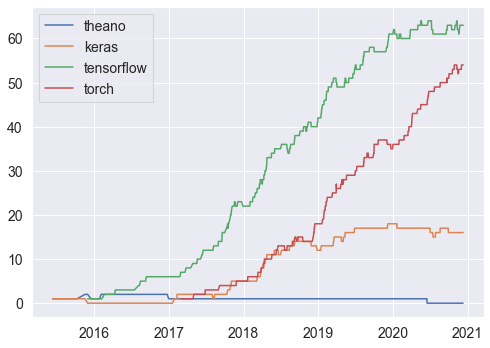

In [9]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

params = dict(
    data=ml_repo_import_diffs_timeline,
    x='date',
    y="count",
    hue='import',
)
ax = sns.lineplot(
    **params,
    markers=True, dashes=False
)
ax.set_xlabel('')
ax.set_ylabel('', fontsize=14)
ax.set_title('')
ax.legend(
    title="",
    fancybox=False,
    fontsize=14
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.tight_layout()
plt.show()
save_plot(fig, 'imports_across_repos.png')

In [10]:
first_releases = releases[releases['release_number'] == 0].sort_values(by='date').reset_index()
dates = list()
project_counts = list()
for i, row in first_releases.iterrows():
    project_counts.append(i + 1)
    dates.append(row['date'])
    
release_counts = pd.DataFrame({
    'date': dates,
    'project_count': project_counts,
})

<ipython-input-11-bdb3ad63a84d>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels, fontsize=14)
<ipython-input-11-bdb3ad63a84d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, fontsize=14)


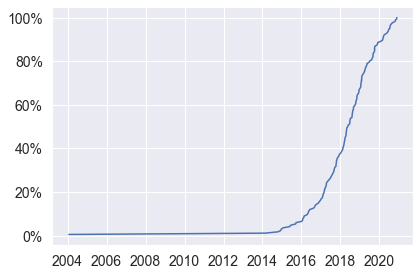

In [11]:
release_counts['percent_reporting'] = release_counts['project_count'] / len(release_counts)
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
params = dict(
    data=release_counts,
    x='date',
    y="percent_reporting",
)
ax = sns.lineplot(
    **params,
    markers=True,
    dashes=False,
    ax=ax,
)
ax.set_xlabel('')
ax.set_ylabel('', fontsize=14)
ax.set_title('')
y_labels = [f"{int(x*100)}%" for x in ax.get_yticks()]
ax.set_yticklabels(y_labels, fontsize=14)
x_labels = [pd.to_datetime(x, unit='D').year for x in ax.get_xticks()]
ax.set_xticklabels(x_labels, fontsize=14)


fig.tight_layout()
plt.show()
save_plot(fig, 'projects_reporting.png')

In [12]:
temp = ml_repo_import_diffs_timeline.copy()
projects_reporting = list()
for i, row in temp.iterrows():
    most_recent_projects_reporting = release_counts.loc[
        release_counts['date'] < row['date']
    ].tail(1)
    projects_reporting.append(most_recent_projects_reporting['project_count'].to_numpy()[0])
temp['projects_reporting'] = projects_reporting
temp['percent_used'] = temp['count'] / temp['projects_reporting']

<ipython-input-13-83d489c822fd>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_yticklabels(y_labels, fontsize=14)
<ipython-input-13-83d489c822fd>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(ax_1.get_xticks(), fontsize=14)
<ipython-input-13-83d489c822fd>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(x_labels, fontsize=14)
<ipython-input-13-83d489c822fd>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_yticklabels(y_labels, fontsize=14)
<ipython-input-13-83d489c822fd>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(x_labels, fontsize=14)
No handles with labels found to put in legend.


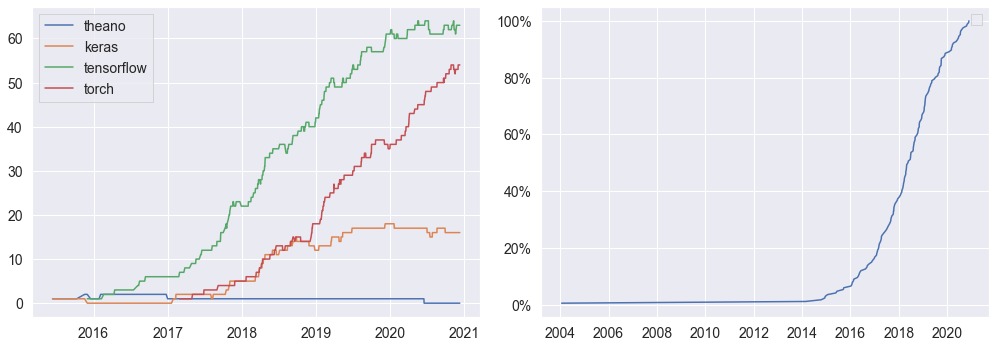

In [13]:
sns.set()
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

params_1 = dict(
    data=ml_repo_import_diffs_timeline,
    x='date',
    y="count",
    hue='import',
)
ax_1 = sns.lineplot(
    **params_1,
    markers=True,
    dashes=False,
    ax=ax_1
)
ax_1.set_xlabel('')
ax_1.set_ylabel('', fontsize=14)
ax_1.set_title('')
y_labels = [f"{int(x)}" for x in ax_1.get_yticks()]
ax_1.set_yticklabels(y_labels, fontsize=14)
ax_1.set_xticklabels(ax_1.get_xticks(), fontsize=14)
x_labels = [pd.to_datetime(x, unit='D').year for x in ax_1.get_xticks()]
ax_1.set_xticklabels(x_labels, fontsize=14)
ax_1.legend(
    title="",
    fancybox=False,
    fontsize=14
)


params_2 = dict(
    data=temp,
    x='date',
    y="percent_used",
    hue='import',
)
ax_2 = sns.lineplot(
    **params,
    markers=True,
    dashes=False,
    ax=ax_2,
)
ax_2.set_xlabel('')
ax_2.set_ylabel('', fontsize=14)
ax_2.set_title('')
y_labels = [f"{int(x*100)}%" for x in ax_2.get_yticks()]
ax_2.set_yticklabels(y_labels, fontsize=14)
x_labels = [pd.to_datetime(x, unit='D').year for x in ax_2.get_xticks()]
ax_2.set_xticklabels(x_labels, fontsize=14)
ax_2.legend(
    title="",
    fancybox=False,
    fontsize=14
)
fig.tight_layout()
plt.show()
save_plot(fig, 'imports_across_repos_with_percent.png')

## What other libraries are imported with DL Libraries?

In [14]:
import_groups = [
    'repo',
    'repo_version',
    'file_in_repo',
]

file_import_records = list()
repo_ver_file_groups = imports.groupby(by=import_groups)
for name, group in repo_ver_file_groups:
    file_records_row = list()
    for row_index, row in group.iterrows():
        if row['primary_import'] not in file_records_row:
            file_records_row.append(row['primary_import'])
    file_import_records.append(file_records_row)

In [15]:
association_rules = apriori(file_import_records, min_support=0.01, min_confidence=0.5, min_lift=3)
association_results = list(association_rules)

formatted_rules = list()
columns = [
    'import',
    'matching_imports',
    'support',
    'confidence',
    'lift',
]
for item in association_results:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(match in ML_LIBRARIES for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for ml_lib in ML_LIBRARIES:
        if ml_lib not in matches:
            continue
        matches.remove(ml_lib)
        formatted_rules.append([
            ml_lib,
            tuple(matches),
            support,
            confidence,
            lift,
        ])

formatted_rules = pd.DataFrame(formatted_rules, columns=columns)

def my_norm(col):
    return (col-col.min())/(col.max()-col.min())

def get_rules_df_for_lib(lib, all_rules):
    result = all_rules[all_rules['import'] == lib].copy()
    result['norm_support'] = my_norm(result['support'])
    result['norm_confidence'] = my_norm(result['confidence'])
    result['norm_lift'] = my_norm(result['lift'])
    result = result.sort_values(by=['lift'], ascending=False)
    return result

tf_rules = get_rules_df_for_lib('tensorflow', formatted_rules)
torch_rules = get_rules_df_for_lib('torch', formatted_rules)
keras_rules = get_rules_df_for_lib('keras', formatted_rules)
theano_rules = get_rules_df_for_lib('theano', formatted_rules)

In [16]:
for_table_imports = [
    'tensorflow',
    'torch',
    'keras',
    'theano',
]
for_table = \
    formatted_rules[formatted_rules['import'].isin(for_table_imports)]\
    .groupby(by='import')\
    .apply(lambda x: x.sort_values(by=["lift"], ascending=False).head(10))\
    .reset_index(drop=True)
for_table

,import,matching_imports,support,confidence,lift
0,keras,"(keras.models, keras.layers)",0.021000,0.536035,20.914729
1,keras,"(keras.models, keras.layers, numpy)",0.016359,0.664697,19.185779
2,keras,"(keras.models, keras.layers, __future__)",0.010640,0.592043,17.430105
3,keras,"(keras.models, __future__)",0.013342,0.742414,16.630155
4,keras,"(keras.layers, __future__)",0.011500,0.639919,16.333870
5,keras,"(keras.layers, numpy)",0.018080,0.559220,14.274044
6,keras,"(keras.models, numpy)",0.019983,0.618066,13.844745
7,keras,"(keras.layers,)",0.024612,0.539442,13.769209
8,keras,"(keras.models,)",0.025630,0.561753,12.583328
9,tensorflow,"(tensorpack, tensorpack.tfutils.summary)",0.010252,0.909677,41.543110


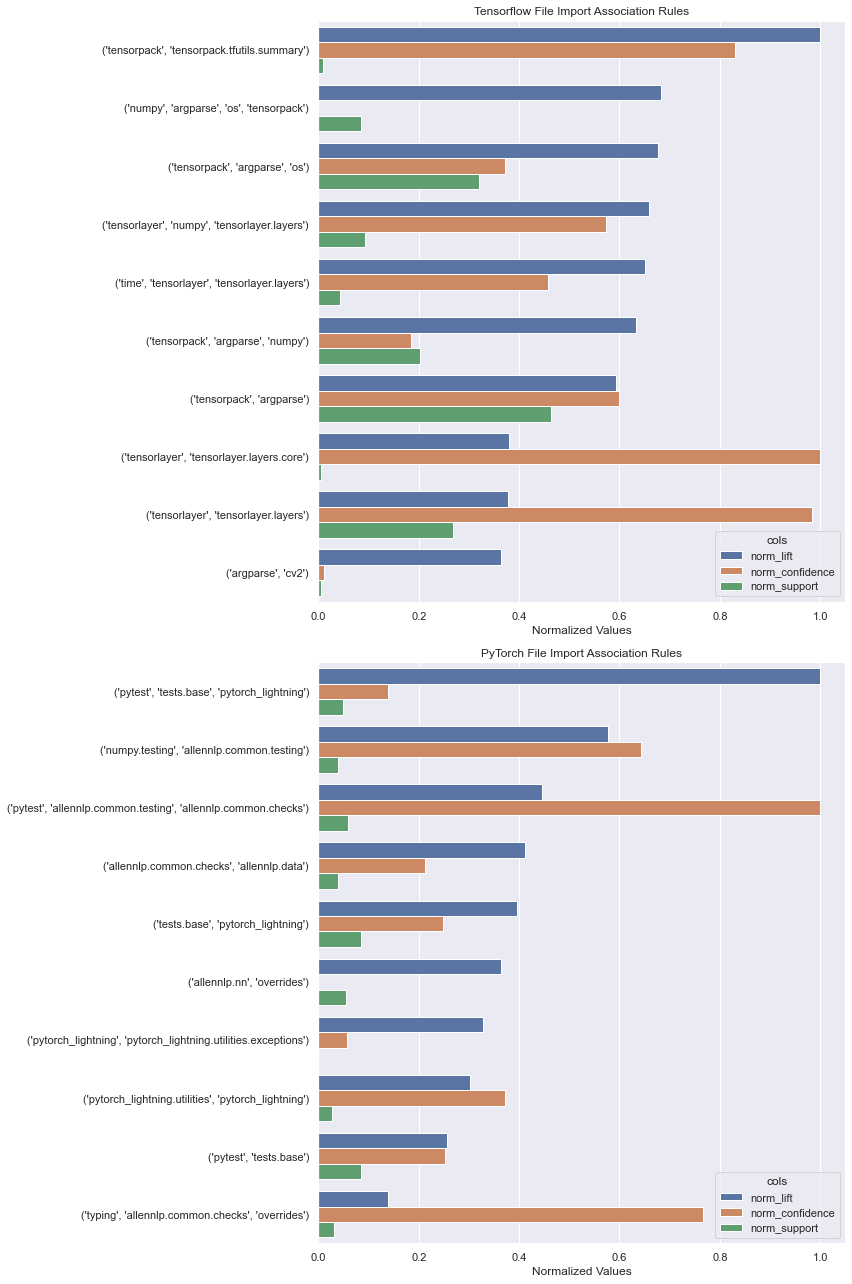

In [17]:
def make_graph_params(df, ax, lib_title):  
    cols_to_drop = ['import','support','confidence','lift']
    for_graph = df\
        .drop(columns=cols_to_drop)\
        .head(10)\
        .melt('matching_imports', var_name='cols',  value_name='vals')
    for_graph['cols'] = for_graph['cols'].astype('category')
    params = dict(
        data=for_graph,
        y='matching_imports',
        x='vals',
        hue='cols',
        hue_order=['norm_lift', 'norm_confidence', 'norm_support']
    )
    ax = sns.barplot(
        **params,
        ax=ax
    )
    ax.set_ylabel('')
    ax.set_xlabel('Normalized Values')
    ax.set_title(f'{lib_title} File Import Association Rules')
    return ax
    
fig, (ax_1, ax_2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

ax_1 = make_graph_params(tf_rules, ax_1, 'Tensorflow')
ax_2 = make_graph_params(torch_rules, ax_2, 'PyTorch')

fig.tight_layout()
plt.show()

## What other libraries change with DL libraries?

In [18]:
add_import_diffs = import_diffs[import_diffs['type'] == 'ADD'].copy()
delete_import_diffs = import_diffs[import_diffs['type'] == 'DELETE'].copy()

import_diffs_groups = [
    'repo',
    'old_release',
    'new_release',
    'file',
]

file_import_diffs_records_add = list()
repo_ver_file_groups = add_import_diffs.groupby(by=import_diffs_groups)
for name, group in repo_ver_file_groups:
    diff_records_row = list()
    for row_index, row in group.iterrows():
        if row['primary_import'] not in diff_records_row:
            diff_records_row.append(row['primary_import'])
    file_import_diffs_records_add.append(diff_records_row)

    
file_import_diffs_records_remove = list()
repo_ver_file_groups = delete_import_diffs.groupby(by=import_diffs_groups)
for name, group in repo_ver_file_groups:
    diff_records_row = list()
    for row_index, row in group.iterrows():
        if row['primary_import'] not in diff_records_row:
            diff_records_row.append(row['primary_import'])
    file_import_diffs_records_remove.append(diff_records_row)


In [19]:
columns = [
    'import',
    'matching_imports',
    'support',
    'confidence',
    'lift',
]

association_diff_rules_add = apriori(file_import_diffs_records_add, min_support=0.01, min_confidence=0.5, min_lift=3)
association_diff_results_add = list(association_diff_rules_add)
formatted_diff_rules_add = list()
for item in association_diff_results_add:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(match in ML_LIBRARIES for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for ml_lib in ML_LIBRARIES:
        if ml_lib not in matches:
            continue
        matches.remove(ml_lib)
        formatted_diff_rules_add.append([
            ml_lib,
            tuple(matches),
            support,
            confidence,
            lift,
        ])

formatted_diff_rules_add = pd.DataFrame(formatted_diff_rules_add, columns=columns)


association_diff_rules_remove = apriori(file_import_diffs_records_remove, min_support=0.01, min_confidence=0.5, min_lift=3)
association_diff_results_remove = list(association_diff_rules_remove)
formatted_diff_rules_remove = list()
for item in association_diff_results_remove:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(match in ML_LIBRARIES for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for ml_lib in ML_LIBRARIES:
        if ml_lib not in matches:
            continue
        matches.remove(ml_lib)
        formatted_diff_rules_remove.append([
            ml_lib,
            tuple(matches),
            support,
            confidence,
            lift,
        ])

formatted_diff_rules_remove = pd.DataFrame(formatted_diff_rules_remove, columns=columns)

### Which imports are added together?

In [20]:
for_table_imports = [
    'tensorflow',
    'torch',
    'keras',
    'theano',
]
for_table_add = \
    formatted_diff_rules_add[formatted_diff_rules_add['import'].isin(for_table_imports)]\
    .groupby(by='import')\
    .apply(lambda x: x.sort_values(by=["lift"], ascending=False).head(10))\
    .reset_index(drop=True)
for_table_add

,import,matching_imports,support,confidence,lift
0,keras,"(keras.layers,)",0.011615,0.517915,18.132334
1,tensorflow,"(tensorlayer, time)",0.011615,0.537162,12.743870
2,tensorflow,"(__future__, sonnet.src)",0.012711,1.000000,10.185268
3,tensorflow,"(numpy, gpflow)",0.010739,0.807692,6.905996
4,tensorflow,"(sys, os)",0.012200,0.784038,5.478658
5,tensorflow,"(argparse, os)",0.011177,0.739130,5.164858
6,tensorflow,"(object_detection.core,)",0.012565,1.000000,4.020264
7,tensorflow,"(sonnet.src,)",0.012711,1.000000,4.020264
8,tensorflow,"(tensorlayer, numpy)",0.012200,0.970930,3.903396
9,tensorflow,"(time, os)",0.012346,0.516820,3.611405


### Which imports are deleted together?

In [21]:
for_table_imports = [
    'tensorflow',
    'torch',
    'keras',
    'theano',
]
for_table_remove = \
    formatted_diff_rules_remove[formatted_diff_rules_remove['import'].isin(for_table_imports)]\
    .groupby(by='import')\
    .apply(lambda x: x.sort_values(by=["lift"], ascending=False).head(10))\
    .reset_index(drop=True)
for_table_remove

,import,matching_imports,support,confidence,lift
0,tensorflow,"(tensorlayer, numpy, time)",0.010843,0.833333,30.469897
1,tensorflow,"(tensorlayer, time)",0.013976,0.517857,18.934865
2,tensorflow,"(__future__, sonnet.src)",0.010241,1.000000,8.773784
3,tensorflow,"(absl.testing, __future__)",0.011205,0.823009,7.220902
4,tensorflow,"(numpy, gpflow)",0.012410,0.895652,7.039690
5,tensorflow,"(argparse, os)",0.010482,0.713115,5.224053
6,tensorflow,"(sys, os)",0.011325,0.706767,5.177551
7,tensorflow,"(numpy, time, os)",0.010843,0.545455,3.995828
8,tensorflow,"(object_detection.core,)",0.013133,1.000000,3.883949
9,tensorflow,"(sonnet.src,)",0.010241,1.000000,3.883949


## Call Statements

In [11]:
tf_prefixes = '^(tensorflow|tf)\.'
torch_prefixes = '^(torch|th)\.'
keras_prefixes = '^keras\.'
theano_prefixes = '^theano\.'
lookup_regex = {
    'tf': tf_prefixes,
    'torch': torch_prefixes,
    'keras': keras_prefixes,
    'theano': theano_prefixes,
}

def call_is_from_lib(call_name, reg_str):
    regexp = re.compile(reg_str)
    return True if regexp.search(call_name) else False

def call_is_from_ml_libs(call_name):
    for key, reg_str in lookup_regex.items():
        if call_is_from_lib(call_name, reg_str):
            return True
    return False

def calls_are_for_ml_lib(loc_calls, key, reg_str):
    for c in loc_calls:
        if call_is_from_lib(c, reg_str):
            return True
    return False

def group_has_ml_call(group):
    for idx, row in group.iterrows():
        if call_is_from_ml_libs(row['name']):
            return True
    return False

def get_ml_lib_from_call(call_name):
    for key, reg_str in lookup_regex.items():
        if call_is_from_lib(call_name, reg_str):
            return key
    return None

In [13]:
filtered_calls = calls.loc[
    ~(calls['name'].str.contains('\(')) & 
    ~(calls['name'].str.contains('\)'))
].copy().reset_index(drop=True)

### What are the most popular calls for each library?

In [38]:
add_call_diffs = call_diffs[call_diffs['type'] == 'ADD'].copy()
delete_call_diffs = call_diffs[call_diffs['type'] == 'DELETE'].copy()

call_diffs_groups = [
    'repo',
    'old_release',
    'new_release',
    'file',
    'call_parent_function'
]

file_call_diffs_records_add = list()
repo_ver_file_parentfunction_groups = add_call_diffs.groupby(by=call_diffs_groups)
for name, group in repo_ver_file_parentfunction_groups:
    diff_records_row = list()
    for row_index, row in group.iterrows():
        if row['call_name'] not in diff_records_row:
            diff_records_row.append(row['call_name'])
    file_call_diffs_records_add.append(diff_records_row)

    
file_call_diffs_records_remove = list()
repo_ver_file_parentfunction_groups = delete_call_diffs.groupby(by=call_diffs_groups)
for name, group in repo_ver_file_parentfunction_groups:
    diff_records_row = list()
    for row_index, row in group.iterrows():
        if row['call_name'] not in diff_records_row:
            diff_records_row.append(row['call_name'])
    file_call_diffs_records_remove.append(diff_records_row)

In [39]:
columns = [
    'lib',
    'matching_calls',
    'support',
    'confidence',
    'lift',
]

association_diff_rules_add = apriori(file_call_diffs_records_add, min_support=0.001, min_confidence=0.5, min_lift=3)
association_diff_results_add = list(association_diff_rules_add)
formatted_diff_rules_add = list()
for item in association_diff_results_add:
    matches = [x for x in item[0]]
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for key, reg_str in lookup_regex.items():
        if calls_are_for_ml_lib(matches, key, reg_str):
            formatted_diff_rules_add.append([
                key,
                tuple(matches),
                support,
                confidence,
                lift,
            ])
formatted_diff_rules_add = pd.DataFrame(formatted_diff_rules_add, columns=columns)


association_diff_rules_remove = apriori(file_call_diffs_records_remove, min_support=0.001, min_confidence=0.5, min_lift=3)
association_diff_results_remove = list(association_diff_rules_remove)
formatted_diff_rules_remove = list()
for item in association_diff_results_remove:
    matches = [x for x in item[0]]
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for key, reg_str in lookup_regex.items():
        if calls_are_for_ml_lib(matches, key, reg_str):
            formatted_diff_rules_remove.append([
                key,
                tuple(matches),
                support,
                confidence,
                lift,
            ])
formatted_diff_rules_remove = pd.DataFrame(formatted_diff_rules_remove, columns=columns)

### Which calls are added together?

In [42]:
for_table_add = \
    formatted_diff_rules_add\
    .groupby(by='lib')\
    .apply(lambda x: x.sort_values(by=["lift"], ascending=False).head(10))\
    .reset_index(drop=True)
for_table_add

,lib,matching_calls,support,confidence,lift
0,tf,"(tape.gradient, tf.GradientTape)",0.001142,0.902439,695.952381
1,tf,"(tf.Graph(), tf.Graph)",0.001683,0.542289,305.473502
2,tf,"(tf.Session, tf.ConfigProto)",0.001343,0.769912,160.886669
3,tf,"(self.test_session, sess.run, tf.global_variables_initializer)",0.001652,0.963964,116.069862
4,tf,"(tf.global_variables_initializer, sess.run, tf.Session)",0.001003,0.631068,113.242611
5,tf,"(self.test_session, sess.run, tf.constant)",0.001204,0.804124,96.823669
6,tf,"(tf.global_variables_initializer, sess.run)",0.003288,0.590028,71.044599
7,torch,"(torch.no_grad, model.eval)",0.001173,0.513514,118.805019
8,torch,"(super(), super, torch.nn.Linear)",0.001173,0.500000,22.508687
9,torch,"(super(), torch.nn.Linear)",0.001173,0.500000,20.500000


### Which calls are deleted together?

In [43]:
for_table_remove = \
    formatted_diff_rules_remove\
    .groupby(by='lib')\
    .apply(lambda x: x.sort_values(by=["lift"], ascending=False).head(10))\
    .reset_index(drop=True)
for_table_remove

,lib,matching_calls,support,confidence,lift
0,tf,"(saver.save, tf.train.Saver)",0.001135,0.758065,261.557527
1,tf,"(tf.Graph(), tf.Graph)",0.001860,0.962500,249.070938
2,tf,"(tf.constant_initializer, tf.truncated_normal_initializer)",0.001256,0.597701,156.627964
3,tf,"(tf.argmax, tf.reduce_mean, tf.equal)",0.001208,0.862069,128.855969
4,tf,"(tf.Session, tf.ConfigProto)",0.001522,0.741176,116.241176
5,tf,"(tf.reduce_mean, tf.nn.sparse_softmax_cross_entropy_with_logits)",0.001087,0.681818,101.913357
6,tf,"(tf.global_variables_initializer, sess.run, tf.Session)",0.001497,0.681319,99.679571
7,tf,"(self.test_session, sess.run, tf.global_variables_initializer)",0.001618,0.917808,92.235271
8,tf,"(self.test_session, sess.run, tf.constant)",0.001304,0.818182,82.223301
9,tf,"(tf.argmax, tf.reduce_mean)",0.001497,0.516667,77.227677


In [25]:
tf_filtered_calls = filtered_calls.loc[
    filtered_calls['name'].str.contains(tf_prefixes, regex=True)
]
popular_tf_filtered_calls = tf_filtered_calls['name'].value_counts().to_frame('counts')
popular_tf_filtered_calls.head(10)

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,counts
tf.placeholder,29863
tf.constant,29754
tf.variable_scope,24030
tf.reshape,20675
tf.cast,15521
tf.shape,15458
tf.reduce_sum,13473
tf.concat,12974
tf.get_variable,12945
tf.reduce_mean,12933


### What calls are used together?

In [118]:
# This will take a while
call_groups = [
    'repo',
    'repo_version',
    'file_in_repo',
    'parent_function'
]

# Filter out calls that do not have a ml call in the same parent function
filtered_calls = filtered_calls\
    .groupby(by=call_groups)\
    .filter(lambda group: group_has_ml_call(group))

,index,file,file_in_repo,repo,repo_version,name,parent_function
0,0,covariance_test.py,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,Covariance,test_covariance_unmasked_computation
1,1,covariance_test.py,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,"np.random.randn(batch_size,num_labels)",test_covariance_unmasked_computation
2,2,covariance_test.py,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,np.random.randn,test_covariance_unmasked_computation
3,3,covariance_test.py,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,"np.random.randn(batch_size,num_labels)",test_covariance_unmasked_computation
4,4,covariance_test.py,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,np.random.randn,test_covariance_unmasked_computation
...,...,...,...,...,...,...,...
4886726,5792859,stylegan2_pytorch.py,stylegan2_pytorch/stylegan2_pytorch.py,lucidrains/stylegan2-pytorch,1.0.1,print,load
4886727,5792860,stylegan2_pytorch.py,stylegan2_pytorch/stylegan2_pytorch.py,lucidrains/stylegan2-pytorch,1.0.1,torch.load,load
4886728,5792861,stylegan2_pytorch.py,stylegan2_pytorch/stylegan2_pytorch.py,lucidrains/stylegan2-pytorch,1.0.1,self.model_name,load
4886729,5792862,stylegan2_pytorch.py,stylegan2_pytorch/stylegan2_pytorch.py,lucidrains/stylegan2-pytorch,1.0.1,self.GAN.load_state_dict,load


In [136]:
# temp = filtered_calls.head(100).copy()
temp_groups = filtered_calls.groupby(by=call_groups)
associated_ml_libs = list()
for name, group in temp_groups:
    group_len = len(group)
    associated_ml_lib = None
    for row_index, row in group.iterrows():
        if get_ml_lib_from_call(row['name']) is not None:
            associated_ml_lib = get_ml_lib_from_call(row['name'])
    for row_index, row in group.iterrows():
        associated_ml_libs.append(associated_ml_lib)

filtered_calls['associated_ml_lib'] = associated_ml_libs
# filtered_calls[['file_in_repo', 'name', 'parent_function', 'associated_ml_lib']].tail(60)

### Cut off call statements

In [195]:
cut_filtered_calls = filtered_calls.head(400000).copy().reset_index()
call_groups = [
    'repo',
    'repo_version',
    'file_in_repo',
    'parent_function'
]

sample_arr = [True, False, False]
bool_arr = np.random.choice(sample_arr, size=len(groups))

cut_records = list()
groups = cut_filtered_calls.groupby(by=call_groups)
sample_arr = [True, False]
bool_arr = np.random.choice(sample_arr, size=len(groups))
count = -1
print(len(groups))
for name, group in groups:
    count += 1
    if bool_arr[count]:
        continue
    records_row = list()
    for row_index, row in group.iterrows():
        if row['name'] not in records_row:
            records_row.append(row['name'])
    cut_records.append(records_row)
print(len(cut_records))


33278
16665


In [196]:
cut_association_rules = apriori(cut_records, min_support=0.01, min_confidence=0.5, min_lift=3)
cut_association_results = list(cut_association_rules)

In [197]:
cut_formatted_rules = list()
columns = [
    'call',
    'matching_calls',
    'support',
    'confidence',
    'lift',
]
for item in cut_association_results:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(call_is_from_ml_libs(match) for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for key, reg_str in lookup_regex.items():
        if calls_are_for_ml_lib(matches, key, reg_str):
            cut_formatted_rules.append([
                key,
                tuple(matches),
                support,
                confidence,
                lift,
            ])

cut_formatted_rules = pd.DataFrame(cut_formatted_rules, columns=columns)
cut_formatted_rules

,call,matching_calls,support,confidence,lift
0,tf,"(box_list.BoxList, tf.constant)",0.013741,0.838828,10.786316
1,tf,"(self.assertAllClose, tf.constant)",0.024602,0.578279,7.435975
2,tf,"(self.test_session, tf.global_variables_initializer)",0.024962,0.553928,7.603964
3,tf,"(sess.run, tf.Session)",0.010501,0.533537,5.935505
4,tf,"(sess.run, tf.global_variables_initializer)",0.035224,0.781625,8.695442
5,tf,"(self.test_session, box_list.BoxList, tf.constant)",0.010981,0.670330,20.091806
6,tf,"(sess.run, box_list.BoxList, tf.constant)",0.011581,0.706960,23.752991
7,tf,"(self.assertAllClose, self.test_session, tf.constant)",0.021362,0.502116,15.049923
8,tf,"(self.assertAllClose, sess.run, tf.constant)",0.018482,0.548043,7.047170
9,tf,"(self.assertAllClose, sess.run, tf.global_variables_initializer)",0.010861,0.815315,9.070247


### Call statements used in same function as TensorFlow

In [148]:
# For Tensorflow
# This will take a while
tf_filtered_calls = filtered_calls[filtered_calls['associated_ml_lib'] == 'tf'].copy().reset_index()
tf_filtered_calls = tf_filtered_calls.drop(columns=['level_0', 'index', 'file'])
call_groups = [
    'repo',
    'repo_version',
    'file_in_repo',
    'parent_function'
]

tf_records = list()
groups = tf_filtered_calls.groupby(by=call_groups)
for name, group in groups:
    records_row = list()
    for row_index, row in group.iterrows():
        if row['name'] not in records_row:
            records_row.append(row['name'])
    tf_records.append(records_row)

In [ ]:
tf_association_rules = apriori(tf_records, min_support=0.01, min_confidence=0.5, min_lift=3)
tf_association_results = list(tf_association_rules)
# tf_association_results

In [156]:
tf_formatted_rules = list()
columns = [
    'call',
    'matching_calls',
    'support',
    'confidence',
    'lift',
]
for item in tf_association_results:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(call_is_from_ml_libs(match) for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for key, reg_str in lookup_regex.items():
        if calls_are_for_ml_lib(matches, key, reg_str):
            tf_formatted_rules.append([
                key,
                tuple(matches),
                support,
                confidence,
                lift,
            ])

tf_formatted_rules = pd.DataFrame(tf_formatted_rules, columns=columns)
tf_formatted_rules

,call,matching_calls,support,confidence,lift
0,tf,"(box_list.BoxList, tf.constant)",0.011276,0.787616,11.593290
1,tf,"(self.assertAllClose, tf.constant)",0.021479,0.557268,8.202684
2,tf,"(self.test_session, tf.global_variables_initializer)",0.021177,0.560535,8.769096
3,tf,"(sess.run, tf.Session)",0.010114,0.500000,6.272798
4,tf,"(sess.run, tf.global_variables_initializer)",0.029164,0.771938,9.684423
5,tf,"(tf.Graph, tf.Graph())",0.010105,0.590368,53.322161
6,tf,"(self.assertAllClose, self.test_session, tf.constant)",0.018216,0.596344,8.777860
7,tf,"(self.assertAllClose, sess.run, tf.constant)",0.015965,0.547583,8.060128
8,tf,"(sess.run, self.test_session, tf.constant)",0.021204,0.758402,9.514606
9,tf,"(sess.run, self.test_session, tf.global_variables_initializer)",0.018988,0.502581,10.013451


### Call statements used in same function as PyTorch

In [162]:
# For PyTorch
# This will take a while
torch_filtered_calls = filtered_calls[filtered_calls['associated_ml_lib'] == 'torch'].copy().reset_index()
torch_filtered_calls = torch_filtered_calls.drop(columns=['level_0', 'index', 'file'])
call_groups = [
    'repo',
    'repo_version',
    'file_in_repo',
    'parent_function'
]

torch_records = list()
groups = torch_filtered_calls.groupby(by=call_groups)
for name, group in groups:
    records_row = list()
    for row_index, row in group.iterrows():
        if row['name'] not in records_row:
            records_row.append(row['name'])
    torch_records.append(records_row)

In [182]:
torch_filtered_calls.head(30)

,file_in_repo,repo,repo_version,name,parent_function,associated_ml_lib
0,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,Covariance,test_covariance_unmasked_computation,torch
1,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,"np.random.randn(batch_size,num_labels)",test_covariance_unmasked_computation,torch
2,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,np.random.randn,test_covariance_unmasked_computation,torch
3,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,"np.random.randn(batch_size,num_labels)",test_covariance_unmasked_computation,torch
4,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,np.random.randn,test_covariance_unmasked_computation,torch
5,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,range,test_covariance_unmasked_computation,torch
6,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,torch.FloatTensor,test_covariance_unmasked_computation,torch
7,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,torch.FloatTensor,test_covariance_unmasked_computation,torch
8,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,np.cov,test_covariance_unmasked_computation,torch
9,allennlp/tests/training/metrics/covariance_test.py,allenai/allennlp,v0.8.1,predictions[UNKNOWN=Tuple],test_covariance_unmasked_computation,torch


In [173]:
torch_association_rules = apriori(torch_records, min_support=0.005, min_confidence=0.5, min_lift=3)
torch_association_results = list(torch_association_rules)
torch_association_results

[RelationRecord(items=frozenset({'trainer.fit', 'Trainer'}), support=0.008464626054665102, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Trainer'}), items_add=frozenset({'trainer.fit'}), confidence=0.6206206206206206, lift=62.70065927996963), OrderedStatistic(items_base=frozenset({'trainer.fit'}), items_add=frozenset({'Trainer'}), confidence=0.8551724137931036, lift=62.700659279969635)]),
 RelationRecord(items=frozenset({'torch.FloatTensor', 'assert_almost_equal'}), support=0.005638533162220462, ordered_statistics=[OrderedStatistic(items_base=frozenset({'assert_almost_equal'}), items_add=frozenset({'torch.FloatTensor'}), confidence=0.597684515195369, lift=43.21618953603159)]),
 RelationRecord(items=frozenset({'self.assertAllClose', 'box_list.BoxList'}), support=0.00746798459984163, ordered_statistics=[OrderedStatistic(items_base=frozenset({'box_list.BoxList'}), items_add=frozenset({'self.assertAllClose'}), confidence=0.5362745098039216, lift=13.15911649752028)]),
 Relatio

In [174]:
torch_formatted_rules = list()
columns = [
    'call',
    'matching_calls',
    'support',
    'confidence',
    'lift',
]
for item in torch_association_results:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(call_is_from_ml_libs(match) for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for key, reg_str in lookup_regex.items():
        if calls_are_for_ml_lib(matches, key, reg_str):
            torch_formatted_rules.append([
                key,
                tuple(matches),
                support,
                confidence,
                lift,
            ])

torch_formatted_rules = pd.DataFrame(torch_formatted_rules, columns=columns)
torch_formatted_rules

,call,matching_calls,support,confidence,lift
0,torch,"(torch.FloatTensor, assert_almost_equal)",0.005639,0.597685,43.216190
1,tf,"(box_list.BoxList, tf.constant)",0.010949,0.786275,10.788959
2,torch,"(torch.cuda.device_count, pytest.mark.skipif)",0.005816,0.507143,40.909896
3,tf,"(self.assertAllClose, tf.constant)",0.022895,0.561809,7.708929
4,tf,"(self.test_session, tf.global_variables_initializer)",0.023797,0.594272,8.513212
5,tf,"(sess.run, tf.global_variables_initializer)",0.030063,0.750767,9.171229
6,torch,"(torch.nn.Linear, super)",0.005543,0.536328,13.294028
7,tf,"(tf.Graph, tf.Graph())",0.007987,0.567961,63.319457
8,tf,"(tf.cast, tf.argmax)",0.006840,0.650649,15.827786
9,tf,"(tf.equal, tf.argmax)",0.005720,0.544156,45.499131


In [155]:
formatted_rules = list()
columns = [
    'call',
    'matching_calls',
    'support',
    'confidence',
    'lift',
]
for item in association_results:
    matches = [x for x in item[0]]
    ml_lib_in_matches = any(call_is_from_ml_libs(match) for match in matches)
    if not ml_lib_in_matches:
        continue
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    for key, reg_str in lookup_regex.items():
        if calls_are_for_ml_lib(matches, key, reg_str):
            formatted_rules.append([
                key,
                tuple(matches),
                support,
                confidence,
                lift,
            ])

formatted_rules = pd.DataFrame(formatted_rules, columns=columns)
formatted_rules

,call,matching_calls,support,confidence,lift
0,tf,"(box_list.BoxList, tf.constant)",0.011276,0.787616,11.593290
1,tf,"(self.assertAllClose, tf.constant)",0.021479,0.557268,8.202684
2,tf,"(self.test_session, tf.global_variables_initializer)",0.021177,0.560535,8.769096
3,tf,"(sess.run, tf.Session)",0.010114,0.500000,6.272798
4,tf,"(sess.run, tf.global_variables_initializer)",0.029164,0.771938,9.684423
5,tf,"(tf.Graph, tf.Graph())",0.010105,0.590368,53.322161
6,tf,"(self.assertAllClose, self.test_session, tf.constant)",0.018216,0.596344,8.777860
7,tf,"(self.assertAllClose, sess.run, tf.constant)",0.015965,0.547583,8.060128
8,tf,"(sess.run, self.test_session, tf.constant)",0.021204,0.758402,9.514606
9,tf,"(sess.run, self.test_session, tf.global_variables_initializer)",0.018988,0.502581,10.013451
